Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, 
реализованное в методичке, заменив механизм предсказания в листе на взятие 
среднего значения по выборке, и критерий Джини на дисперсию значений.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

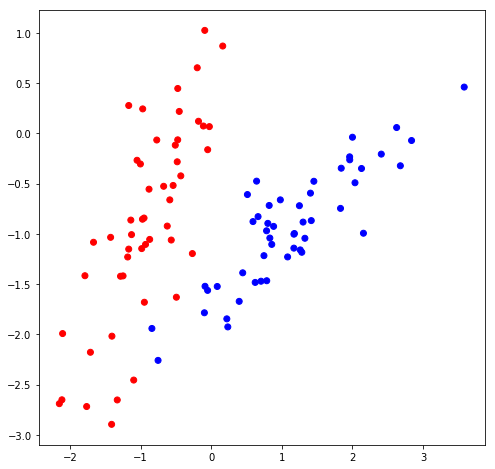

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        return self.labels.mean()        

In [6]:
# Расчет критерия MSE/ не Джини!

def gini(labels):
    #  подсчет количества объектов разных классов
    labs = labels - labels.mean()
    return np.dot(labs,labs) / labels.shape[0]

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    # C.  Критерий останова по мин количеству объектов в узле (этот критерий уже есть в оригинале)
    #  обозначим минимальное количество объектов в узле   
    min_leaf = 6

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = 1 #data.shape[1] # здесь только одна независимая переменная - х
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, level, num_leafs):
    max_num_leafs = 3
    max_level     = 5  
    eps = 0.01
    
    # B.  Критерий останова по макс количеству листьев
    if num_leafs> max_num_leafs:
        print('превышение максимального числа листьв!')
        num_leafs += 1
        return Leaf(data, labels),num_leafs
    
    
    # D.  Критерий останова по точному определению классa
    length = len(labels)
    print(length,len(labels[labels==0]),len(labels[labels==1]))
    if len(labels[labels==0])==length or len(labels[labels==1])==length:
        print('все объекты одного класса!')
        num_leafs += 1
        return Leaf(data, labels),num_leafs
    
    
    # A.  Критерий останова по макс глубине
    # первый вызов делается с level = 0
    level += 1
    if level> max_level:
        print('превышение максимальной глубины дерева!')
        num_leafs += 1
        return Leaf(data, labels),num_leafs
    
    
    quality, t, index = find_best_split(data, labels)

    # E.  Критерий останова по 
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    #    if quality == 0:
    if quality < eps:
        print('останов по недостаточному улучшению качества! q=',quality)
        num_leafs += 1
        return Leaf(data, labels),num_leafs
    
    

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch,num_leafsL = build_tree( true_data,  true_labels,  level, num_leafs)
    false_branch,num_leafsR = build_tree(false_data, false_labels, level, num_leafs)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    num_leafs = num_leafsL + num_leafsR
    return Node(index, t, true_branch, false_branch),num_leafs

In [11]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)
train_labels = train_data[:,1].copy()
test_labels  =  test_data[:,1].copy()

In [14]:
# Построим дерево по обучающей выборке
num_leafs = 0

my_tree, num_leafs = build_tree(train_data, train_labels, 0, 0)
print(num_leafs)

70 0 0
9 0 0
останов по недостаточному улучшению качества! q= 0
61 0 0
52 0 0
31 0 0
18 0 0
6 0 0
превышение максимальной глубины дерева!
12 0 0
превышение максимальной глубины дерева!
13 0 0
7 0 0
превышение максимальной глубины дерева!
6 0 0
превышение максимальной глубины дерева!
21 0 0
9 0 0
останов по недостаточному улучшению качества! q= 0
12 0 0
останов по недостаточному улучшению качества! q= 0.00010115461913432627
9 0 0
останов по недостаточному улучшению качества! q= 0
8


In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -1.2499312777434102
--> True:
  Прогноз: -1.85336005049842
--> False:
  Индекс 0
  Порог 1.8320652455044126
  --> True:
    Индекс 0
    Порог 0.16261402870113306
    --> True:
      Индекс 0
      Порог -0.4942656820712277
      --> True:
        Индекс 0
        Порог -0.9715037016309751
        --> True:
          Прогноз: -0.642834876715078
        --> False:
          Прогноз: -0.9737650537294734
      --> False:
        Индекс 0
        Порог -0.09195833713035761
        --> True:
          Прогноз: -0.254058537154527
        --> False:
          Прогноз: -0.6381679726568997
    --> False:
      Индекс 0
      Порог 0.7469239043288685
      --> True:
        Прогноз: -1.309714843709416
      --> False:
        Прогноз: -0.9221842684400515
  --> False:
    Прогноз: -0.3175047707405911


In [24]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [25]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [28]:
# Введем функцию подсчета точности как дисперсия ответов в "листе"
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        correct += (actual[i] - predicted[i])**2
    return correct / float(len(actual)) * 100.0

In [29]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

33.67758429836434

In [30]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

38.00535528189488

Text(0.5, 1.0, 'Test dispersion=38.01')

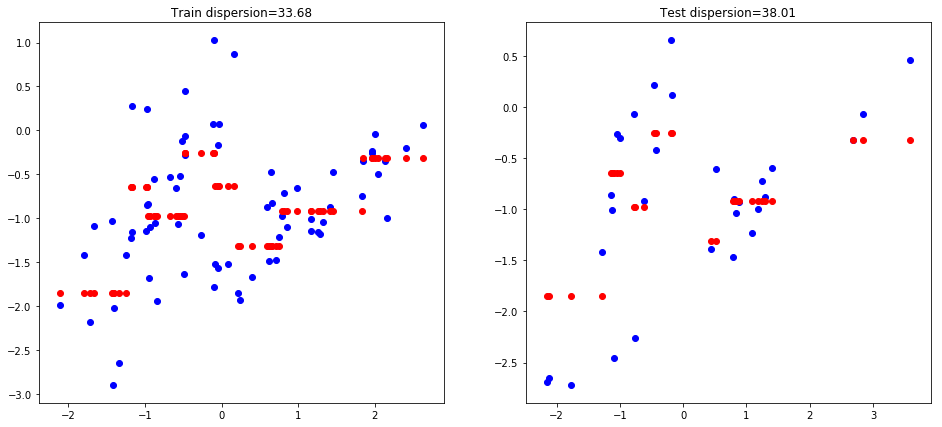

In [32]:
# Визуализируем дерево на графике
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
plt.scatter(train_data[:, 0], train_data[:, 1], c = 'b')
plt.scatter(train_data[:, 0], train_answers,     c = 'r')
plt.title(f'Train dispersion={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.scatter(test_data[:, 0], test_data[:, 1], c = 'b')
plt.scatter(test_data[:, 0], answers,     c = 'r')
plt.title(f'Test dispersion={test_accuracy:.2f}')
